<a href="https://colab.research.google.com/github/pankajti/qtw/blob/master/Risk_GWP_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 4

In [2]:
!pip install hmms
!pip install pgmpy
!pip install fredapi
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
!pip install pygraphviz
from IPython.display import clear_output
clear_output()

In [3]:
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm
from pgmpy.estimators import BicScore, K2Score, BDeuScore
from statsmodels.tsa.seasonal import seasonal_decompose
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch
from matplotlib.collections import LineCollection
from statsmodels.graphics import tsaplots
from pgmpy.models import BayesianModel
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import plotly.express as px
from fredapi import Fred
import seaborn as sns
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import datetime
import hmms
import os

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
os.makedirs('hmms',exist_ok=True)
os.makedirs('plots', exist_ok=True)

In [5]:
datasets_eia  = [
#'STEO.RGDPQ_NONOECD.M',
#'STEO.RGDPQ_OECD.M',
'STEO.PAPR_NONOPEC.M',
'STEO.PAPR_OPEC.M',
'STEO.PATC_OECD.M',
'STEO.PATC_NON_OECD.M',
'STEO.COPRPUS.M',
#'STEO.CORIPUS.M',
#'PET.MCRIMXX2.M',
##'STEO.FOREX_WORLD.M',
# 'STEO.PASC_OECD_T3.M',
# 'STEO.COPS_OPEC.M',
#'STEO.COPC_OPEC.M',
#'STEO.T3_STCHANGE_OOECD.M',
#'STEO.T3_STCHANGE_NOECD.M',
                  ]

datasets_fred=[
'CPIENGSL',
'CAPG211S',
'CAPUTLG211S',
'IPG211S',
'IPG211111CN',
'INDPRO',
'IPN213111N',
'PCU211211',]

datasets = datasets_eia + datasets_fred + ['WTISPLC', 'forecast'];
updated_dataset= [d for d in datasets if d not in ['STEO.COPC_OPEC.M','STEO.RGDPQ_NONOECD.M','STEO.RGDPQ_OECD.M',
                                                   'STEO.FOREX_WORLD.M','STEO.CORIPUS.M']]


In [6]:
eia_key = r'KhUGeRcdKwP8WpygPCSDasWyaRburTqyE9er7aUN'
url_data = 'http://api.eia.gov/v2/seriesid/{}?api_key={}&out=json'

def convert_to_datetime(input):
    return datetime.datetime.strptime(input[:9].replace("-"," ").strip(), "%Y %m").date();
def clean_EIA(data):
    data.replace('-', np.nan, regex=True, inplace=True);
    data.fillna(method='bfill', inplace=True);
    data.index = data.index.map(convert_to_datetime);
    data.index = pd.to_datetime(data.index);
data_merge=[]
for series_id in datasets_eia:
    #df = pd.DataFrame(eia_api.data_by_series(series=series_id));
    print(f"downloading data for {series_id}")
    values_dict = {}
    search = requests.get(url_data.format(series_id, eia_key))
    eia_data = pd.DataFrame(search.json().get('response').get('data'))
    if len(eia_data)==0:
        print(f"No data for series {series_id}")
        continue
    df = eia_data.set_index('period')[['value']]
    clean_EIA(df);
    df.columns = [series_id];
    data_merge.append(df);


fred_key = r'484b16395bfa70e86d649f7d42dc1d4b'
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);
# Retrieve data from FRED API
for series_id in datasets_fred:
    print(f"downloading data for {series_id}")

    df = pd.DataFrame(fred.get_series(series_id), columns=[series_id]);
    data_merge.append(df);

current = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC']);
forecast = pd.DataFrame(fred.get_series('WTISPLC').shift(-1),
columns=['forecast']);
data_merge.append(current);
data_merge.append(forecast);

data = pd.concat(data_merge, axis=1, join='inner');
data.to_csv("downloaded_data.csv")

print("done")

downloading data for STEO.PAPR_NONOPEC.M
downloading data for STEO.PAPR_OPEC.M
downloading data for STEO.PATC_OECD.M
downloading data for STEO.PATC_NON_OECD.M
downloading data for STEO.COPRPUS.M
downloading data for CPIENGSL
downloading data for CAPG211S
downloading data for CAPUTLG211S
downloading data for IPG211S
downloading data for IPG211111CN
downloading data for INDPRO
downloading data for IPN213111N
downloading data for PCU211211
done


In [7]:
train_data = data[: int(data.shape[0] * 0.80)];
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])];
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])];
for series_id in updated_dataset:
    print(f"running for {series_id}")
    if series_id in ['forecast']:
        break
    else:
        dhmm = hmms.DtHMM.random(3,2);
        data_diff = train_data[series_id].diff()[1:];
        emit_seq = np.array_split(data_diff.apply(
        lambda x: 1 if x > 0 else 0).values, 32);
        dhmm.baum_welch(emit_seq, 100);
        path = "./hmms/" + series_id.replace(".", "_");

        dhmm.save_params(path);

disc_test = pd.DataFrame(index = train_data[1:].index);
np.int = int
for series_id in updated_dataset:
    print(f"running for {series_id}")

    path = "./hmms/" + series_id.replace(".", "_") + ".npz";
    if series_id == 'forecast':
        dhmm = hmms.DtHMM.from_file('./hmms/WTISPLC.npz');
    else:
        dhmm = hmms.DtHMM.from_file(path);
    data_diff = train_data[series_id].diff()[1:];
    emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values);
    ( log_prob, s_seq ) = dhmm.viterbi(emit_seq);
    disc_test[series_id] = s_seq;
disc_test.to_csv("./train_data.csv");
clear_output()

In [8]:
data = pd.read_csv(r'downloaded_data.csv').set_index('Unnamed: 0')
train_data = data[: int(data.shape[0] * 0.80)];
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])];
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])];
# Retrieve training set
train_data = pd.read_csv("train_data.csv", index_col=0);
#train_data=train_data.set_index('Unnamed: 0')

In [9]:
train_data=train_data[updated_dataset]

In [10]:
hc = HillClimbSearch(train_data);
expert = BayesianModel();
expert.add_nodes_from(train_data.columns);
expert.add_edges_from([
('STEO.PAPR_NONOPEC.M', 'WTISPLC'),
('STEO.PAPR_OPEC.M', 'WTISPLC'),
('STEO.PATC_OECD.M', 'WTISPLC'),
('STEO.PATC_NON_OECD.M', 'WTISPLC'),
#('STEO.RGDPQ_OECD.M', 'STEO.PATC_OECD.M'),
#('STEO.RGDPQ_NONOECD.M', 'STEO.PATC_NON_OECD.M'),
]);

model = hc.estimate(start_dag=expert, scoring_method=K2Score(train_data)); # Performs local hill climb search
print("fitting model estimate done")
model.fit(train_data,
state_names=dict(map(lambda e: (e, [0, 1, 2]), updated_dataset)),
estimator=BayesianEstimator, prior_type="K2");
discrete_vald = pd.DataFrame(index = vald_data[1:].index);
for series_id in updated_dataset:
    path = "./hmms/" + series_id.replace(".", "_") + ".npz";
    if series_id == 'forecast':
        dhmm = hmms.DtHMM.from_file('./hmms/WTISPLC.npz');
    else:
        dhmm = hmms.DtHMM.from_file(path);
    data_diff = vald_data[series_id].diff()[1:];
    emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values);
    ( log_prob, s_seq ) = dhmm.viterbi(emit_seq);
    discrete_vald[series_id] = s_seq;
discrete_vald.to_csv("./validation_data.csv");



  0%|          | 0/1000000 [00:00<?, ?it/s]

fitting model estimate done


In [11]:
#data[updated_dataset]

In [12]:
vald_real = data['WTISPLC'].to_numpy();
# Drop the real data observation so that it does not bias prediction
#new_data = data[data_columns]
#vald_data_new = data[updated_dataset].drop(['forecast'], axis=1)
# Inference on the constructed graphical model
vald_data_new = discrete_vald.drop(['forecast'], axis=1)

vald_prediction = model.predict(vald_data_new);
# Retrieve it as an array so we can compare with real value


  0%|          | 0/33 [00:00<?, ?it/s]

In [13]:
pred_value_vald = vald_prediction['forecast'].to_numpy();
vald_real = discrete_vald['WTISPLC'].to_numpy();

print("\nPredicted Value: ");
print(pred_value_vald);
print("\nReal Value: ");
print(vald_real);
error = np.mean(vald_real != np.roll(pred_value_vald, 1));
#error = np.mean(vald_real != pred_value_vald);
print("\nError: ");
print(error * 100);


Predicted Value: 
[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Real Value: 
[0 0 1 2 0 1 2 0 1 2 0 0 0 1 2 0 1 2 2 0 1 2 0 0 0 0 1 2 0 0 1 2 0]

Error: 
54.54545454545454


In [14]:
discrete_test = pd.DataFrame(index = test_data[1:].index);
for series_id in datasets:
  path = "./hmms/" + series_id.replace(".", "_") + ".npz";
  if series_id == 'forecast':
    dhmm = hmms.DtHMM.from_file('./hmms/WTISPLC.npz');
  else:
    dhmm = hmms.DtHMM.from_file(path);
  data_diff = test_data[series_id].diff()[1:];
  emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values);
  ( log_prob, s_seq ) = dhmm.viterbi(emit_seq);
  discrete_test[series_id] = s_seq;
discrete_test.to_csv("./test_data.csv");

In [15]:
discrete_test = pd.read_csv("./test_data.csv", index_col=0);
# Record real data observation, to be compared with the predicted one
test_real = discrete_test['WTISPLC'].to_numpy();
# Drop the real data observation so that it does not bias prediction
test_data_new = discrete_test.drop(['forecast'], axis=1);
# Inference on the constructed graphical model
test_prediction = model.predict(test_data_new);
# Retrieve it as an array so we can compare with real value


  0%|          | 0/33 [00:00<?, ?it/s]

In [16]:
pred_value_test = test_prediction['forecast'].to_numpy();
print("\nPredicted Value: ");
# This is the price, not the forecast
print(pred_value_test);
print("\nReal Value: ");
print(test_real);
# Shift to get forecast
error = np.mean(test_real != np.roll(pred_value_test, 1));
#error = np.mean(test_real != pred_value_test); # Shift to get forecast
print("\nError: ");
print(error * 100);


Predicted Value: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Real Value: 
[1 2 0 1 2 2 0 0 0 1 2 0 0 1 2 0 0 0 0 1 2 0 1 2 0 0 0 1 2 2 2 0 0]

Error: 
51.515151515151516


In [17]:
test_price = pd.DataFrame(test_data['WTISPLC'], columns=['WTISPLC']).reset_index();
test_signal = pd.DataFrame(test_prediction)
test_signal.columns=['forecast'];
test_sheet = pd.concat([test_price, test_signal], axis=1, join='inner');
trades = [test_sheet['WTISPLC'].iloc[0]];
position = False; # True for Long, False for Short
for i in range(len(test_sheet)-1):
  if test_sheet['forecast'].iloc[i+1] == 0:
    trades.append(trades[-1]);
  elif test_sheet['forecast'].iloc[i+1] == 2:
    if position == False:
      position = True;
      trades.append(trades[-1]);
    else:
      trades.append(test_sheet['WTISPLC'].iloc[i+1]);
  else:
    if position == False: # If Short, remains same price
        trades.append(trades[-1]);
    else: # If Long, price inc
      trades.append(test_sheet['WTISPLC'].iloc[i+1]);
# eia_forecast = pd.read_csv("./eia_forecast.csv", index_col=0);
# eia_forecast.index = test_signal.index;

In [33]:
test_prediction

,forecast
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [28]:
map_regime_names= {0: 'Bear', 1: 'Stagnant', 2: 'Bull'}

In [30]:
states = pd.read_csv("./validation_data.csv", index_col=0);
for series_id in datasets:
  df = pd.DataFrame(index=vald_data[1:].index);
  df[series_id] = vald_data[series_id][1:];
  df['Diff'] = vald_data[series_id].diff()[1:];
  df['Regime'] = states[series_id];
  # Get means of all assigned states
  means = df.groupby(['Regime'])['Diff'].mean();
  lst_1 = means.index.tolist();
  lst_2 = means.sort_values().index.tolist();
  map_regimes = dict(zip(lst_2, lst_1));
  df['Regime'] = df['Regime'].map(map_regimes);
  df['Regime_name'] = df.Regime.apply(lambda x:map_regime_names[x])
  df.index.name='Date'
  fig= px.scatter(df, y=series_id,color= 'Regime_name',color_discrete_sequence=px.colors.qualitative.Antique)
  fig.show()


## Step 5


In [32]:
#test_signal

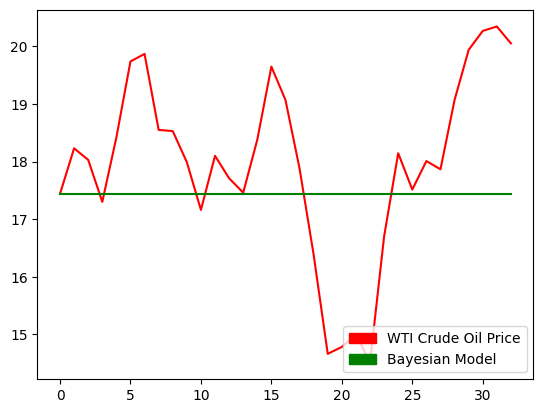

In [20]:
test_performance = pd.DataFrame(trades, index = test_signal.index,
columns=['performance']);
test_sheet = pd.concat([test_sheet, test_performance], axis=1, join='inner');
plt.plot(test_sheet['WTISPLC'], 'r');
plt.plot(test_sheet['performance'], 'g');
#plt.plot(eia_forecast['eia_forecast'], 'b');
r_patch = mpatches.Patch(color='red', label='WTI Crude Oil Price');
g_patch = mpatches.Patch(color='green', label='Bayesian Model');
#b_patch = mpatches.Patch(color='blue', label='EIA Forecast');
#plt.legend(handles=[r_patch, g_patch, b_patch], loc = 'lower right');
plt.legend(handles=[r_patch, g_patch], loc = 'lower right');
plt.show()

In [35]:
import hmms
from fredapi import Fred
import numpy as np
import  pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm

# FRED API key
fred_key = r'484b16395bfa70e86d649f7d42dc1d4b'
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);
# Retrieve data from FRED API
fred_data = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC']);
price = fred_data['WTISPLC']
price_diff = price.diff()[1:];

e_seq = np.array(price_diff.apply(lambda x: 1 if x > 0 else 0).values);
dhmm_r = hmms.DtHMM.random(3 , 2);
e_seq = np.array_split(e_seq, 32);
dhmm_r.baum_welch(e_seq, 100);
hmms.print_parameters( dhmm_r );
( log_prob, s_seq ) = dhmm_r.viterbi(np.concatenate(e_seq).ravel());

price_plot = pd.DataFrame(price[1:], index=price[1:].index);
# Add a column representing the regime
price_plot['Regime'] = s_seq;
# Add a column representing the increase or decrease in price
price_plot['diff'] = price_diff;

means = price_plot.groupby(['Regime'])['diff'].mean();
lst_1 = means.index.tolist();
lst_2 = means.sort_values().index.tolist();
map_regimes = dict(zip(lst_2, lst_1));
price_plot['Regime'] = price_plot['Regime'].map(map_regimes);


iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

,0
0,0.482532
1,0.031780
2,0.485688


Transition probabilities matrix (A):


,0,1,2
0,5.822251e-02,9.231243e-01,0.018653
1,6.326188e-01,3.665233e-01,0.000858
2,3.393930e-22,2.866470e-23,1.000000


Emission probabilities matrix (B):


,0,1
0,0.911357,0.088643
1,0.949688,0.050312
2,0.435608,0.564392


AttributeError: 'DataFrame' object has no attribute 'show'

In [41]:
df

,forecast,Diff,Regime,Regime_name
Date,,,,
1998-07-01,13.36,-1.59,1,Stagnant
1998-06-01,14.08,0.72,2,Bull
1998-05-01,13.66,-0.42,0,Bear
1998-04-01,14.86,1.20,1,Stagnant
1998-03-01,15.44,0.58,2,Bull
1998-02-01,15.02,-0.42,0,Bear
1998-01-01,16.06,1.04,1,Stagnant
1997-12-01,16.71,0.65,2,Bull
1997-11-01,18.32,1.61,0,Bear


In [37]:
price_plot

,WTISPLC,Regime,diff
1946-02-01,1.17,0,0.00
1946-03-01,1.17,1,0.00
1946-04-01,1.27,0,0.10
1946-05-01,1.27,1,0.00
1946-06-01,1.27,0,0.00
...,...,...,...
2023-09-01,89.43,2,8.04
2023-10-01,85.64,2,-3.79
2023-11-01,77.69,2,-7.95
2023-12-01,71.90,2,-5.79


AttributeError: 'Index' object has no attribute 'to_pydatetime'

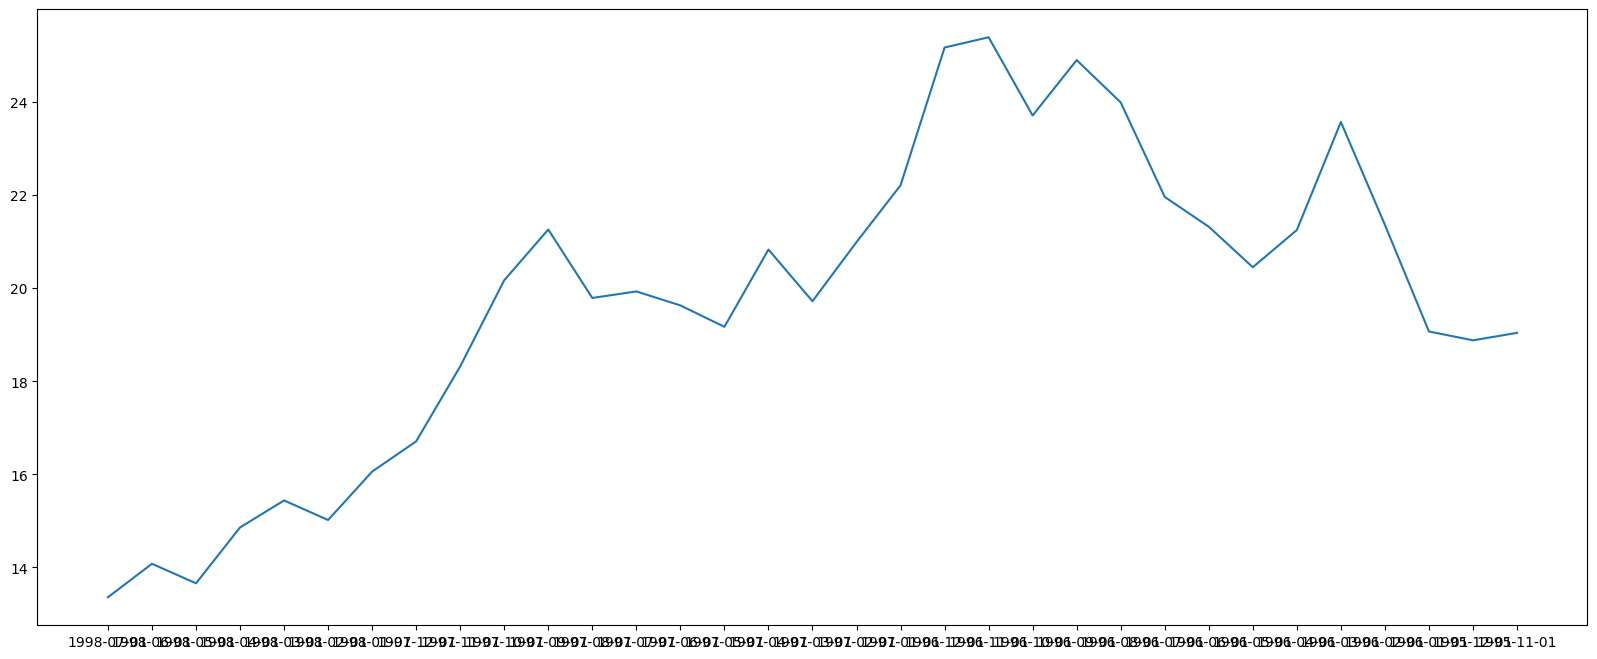

In [42]:
price_plot=df
price_plot['WTISPLC']=df['forecast']
fig, ax1 = plt.subplots(figsize=(20,8));
ax1.plot(price_plot['WTISPLC']);
# Make 0 (Bear) - red, 1 (Stagnant) - blue, 2 (Bull) - green
cmap = ListedColormap(['r','b','g'],'indexed');
norm = BoundaryNorm(range(3 + 1), cmap.N);
inxval = mdates.date2num(price_plot['WTISPLC'].index.to_pydatetime());
points = np.array([inxval, price_plot['WTISPLC']]).T.reshape(-1, 1, 2);
segments = np.concatenate([points[:-1], points[1:]], axis=1);
lc = LineCollection(segments, cmap=cmap, norm=norm);
lc.set_array(price_plot['Regime']);
plt.gca().add_collection(lc);
plt.xlim(price_plot['WTISPLC'].index.min(), price_plot['WTISPLC'].index.max());
plt.ylim(price_plot['WTISPLC'].min(), price_plot['WTISPLC'].max());
r_patch = mpatches.Patch(color='red', label='Bear');
g_patch = mpatches.Patch(color='green', label='Bull');
b_patch = mpatches.Patch(color='blue', label='Stagnant');
plt.legend(handles=[r_patch, g_patch, b_patch]);
plt.show();



In [39]:
price_plot

,WTISPLC,Regime,diff
1946-02-01,1.17,0,0.00
1946-03-01,1.17,1,0.00
1946-04-01,1.27,0,0.10
1946-05-01,1.27,1,0.00
1946-06-01,1.27,0,0.00
...,...,...,...
2023-09-01,89.43,2,8.04
2023-10-01,85.64,2,-3.79
2023-11-01,77.69,2,-7.95
2023-12-01,71.90,2,-5.79
